<a href="https://colab.research.google.com/github/sayam47/Mellowmax-RL/blob/master/FrozenLake_Mellowmax_vs_Boltzmann.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from collections import deque
from collections import defaultdict
import gym
import sys
import math
import numpy as np
import warnings
warnings.filterwarnings('ignore')


In [0]:
def interact(env, agent, num_episodes=5000, window=100):
    avg_rewards = deque(maxlen=num_episodes)
    best_avg_reward = -math.inf
    samp_rewards = deque(maxlen=window)
    for i_episode in range(1, num_episodes+1):
        state = env.reset() #initialize the environment
        samp_reward = 0
        while True:
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            samp_reward += reward
            state = next_state
#             print("\rRewards : {}".format(samp_reward),end="")
            if done:
                samp_rewards.append(samp_reward)
                break
        
        avg_reward=0
        if (i_episode >= 100):
            avg_reward = np.mean(samp_rewards)
            avg_rewards.append(avg_reward)
            if avg_reward > best_avg_reward:
                best_avg_reward = avg_reward
        averages_history.append(samp_reward)
        if samp_reward >= 1:
#             print('\nEnvironment solved in {} episodes.'.format(i_episode), end="")
            return i_episode
            break
#         if i_episode == num_episodes: print('\n')
    return 10000

In [0]:
from scipy.optimize import brentq

class Agent:

    def __init__(self, nA=4,omega=25,beta=1,mellow=0):
        self.mellow=mellow
        self.beta=beta
        self.nA = nA
        self.omega=omega
        self.Q = defaultdict(lambda: np.zeros(self.nA))
        self.epsilon_function = None;
        self.next_value_function = None;
        self.gamma = 0.9
        self.alpha = 0.1
           
    def mellowmax(self,beta,state):
        c=np.max(self.Q[state])
        mellow=c+np.log(np.sum(np.exp(self.omega*(self.Q[state]-c)))/self.nA)/self.omega
        ans=np.sum(np.exp((self.Q[state]-mellow)*beta)*(self.Q[state]-mellow))
        return ans

    def get_action_probability(self, state):
        if self.mellow==1:
            beta=brentq(self.mellowmax,-500,500,args=(state,))
        else:
            beta=self.beta
        policy_s = np.exp(beta*self.Q[state])/np.sum(np.exp(beta*self.Q[state]))
        return policy_s

    def select_action(self, state):
        policy_s = self.get_action_probability(state)
        return np.random.choice(np.arange(self.nA), p=policy_s)
    
    def step(self, state, action, reward, next_state, done):
        next_action_value = self.Q[next_state][self.select_action(next_state)]
        self.Q[state][action] += self.alpha * (reward  + self.gamma * next_action_value - self.Q[state][action])

In [0]:
env = gym.make('FrozenLake-v0')


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
iteration = 50
his_b=[] #history_of_values
solve_his_b=[]
for i in range(1,31):
    b=0
    for j in range(iteration):
        averages_history=[]
        agent = Agent(beta=i)
        sol=interact(env,agent)
        b+=sol
    b/=iteration
    solve_his_b.append(b)
#         his.append(averages_history)
    

In [0]:
iteration=50
his_m=[]
solve_his_m=[]
for i in range(1,31):
    b=0
    for j in range(iteration):
        averages_history=[]
        agent = Agent(omega=i,mellow=1)
        sol=interact(env,agent)
        b+=sol
    b/=iteration
    solve_his_m.append(b)
#         his.append(averages_history)
    

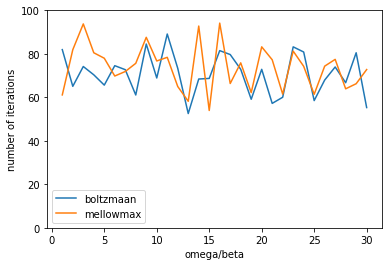

In [8]:
fig_best=plt.figure()
ax=fig_best.add_subplot(111)
plt.plot(np.arange(1,31),solve_his_b,label='boltzmaan')
plt.plot(np.arange(1,31),solve_his_m,label='mellowmax')
plt.xlabel('omega/beta')
plt.ylabel('number of iterations')
plt.ylim(0,100)
plt.legend()
plt.savefig('lake.png')